# Overview of the steps this code will take:
### 1. load in the data
### 2. convert data for training
### 3. perform train_test_split
### 4. fit the training data to the lda
### 5. plot the confusion matrix
### 6. get analysis of the fit

In [1]:
#import libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import function to construct a train/test split of the data
from sklearn.model_selection import train_test_split
#import function to construct a confusion matrix 
from sklearn.metrics import confusion_matrix
#import methods to run LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import function to get precision,recall, F1 score given true labels y and predicted labels y_pred
from sklearn.metrics import precision_recall_fscore_support
#import function to find the standardization factor of a given set of numbers
from sklearn.preprocessing import StandardScaler
#import thisto do resampling
from sklearn.utils import resample
#import seaborn for plotting
import seaborn as sns
import os
%matplotlib inline

After importing all the necessary packages, load in the data as a csv. 
This file contains all the x,y points for each of the species

In [2]:
# #read in the procrustes data
df = pd.read_csv('Procrustes_all.csv')

#set the name of prediction type (column name)
label_name = 'bin'

#set the name of prediction type for graphing purposes (not column name)
print_label = label_name

In order to ensure that all the bins are equally sampled, we are going to upsample (with resample) the bin data. So this means that all the bins will have the same number of objects, and the ones that were upsampled are also randomly sampled. 

In [3]:
#set parameters

#set this to true to allow upsampling. Note resample needs to be true also. 
upsample = True

#set cutoff value to upsample minority classes
#any class with fewer obs. than this will be upsampled to have this many obs.
#Bin #1 has 1184, so this is set to 1184 so that all other bins will be upsampled to also have 1184 
minority_cutoff = 1184

In [4]:
# get the number of counts for the number of bins. After this, each bin will have the same number of observations. 
class_cnts = df[label_name].value_counts() 

#do upsampling 
if upsample == True:
    #find minority classes
    minority_class = class_cnts[class_cnts < minority_cutoff].index
        
    #remove the minority class data from the data frame
    #will put the resampled data from these classes back in
    data_resampled=df[~df[label_name].isin(minority_class)]
    
    #upsample each species below the minority cutoff
    for s in minority_class:
        # Separate minority class
        data_minority = df[df[label_name] == s]
        # Upsample minority specie
        data_minority_upsampled = resample(data_minority, 
                                         replace=True,     # sample with replacement
                                         n_samples=minority_cutoff,    # to match majority class
                                         random_state=40) # reproducible results
        #concat each upsampled minority obs. into one dataframe
        data_resampled = pd.concat([data_resampled,data_minority_upsampled])
    #set the main df now to the data of upsampled class obs., and the non-upsampled original obs.  
    df = data_resampled

After we load in the data, we need to format it correctly for the train_test_split function. This involves making a new df to put the newly computed variables in. Then we will run the function.

Train_test_split we have set for 80% of our data randomized for training, and the other 20% will be tested against the training set. This split ratio is arbitrary, but conventional. If the training set was less the model could be overfitted, and if it was more the model would be underfitted.  

In [5]:
#set the input (X) and target data (y)
#set predictors (input / input variables / etc.)

X=df[['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5',
       'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11',
       'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16',
       'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21',
       'y21']]
#set prediction values (labels/classes/response variables)
y=df[[label_name]]

#put prediction values in proper format for learning process
y=y.values
y=y.flatten()

#set the unique class labels
classes = np.unique(y)

#convert to string if needed (for integers etc.)
y=list(map(str, y))
classes = list(map(str,classes))

#define the data split for training and testing. This will be for the confusion matrix only. 
#we will use cross validation for the other performance metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize the both the training and test data using the training standard scalar
sc = StandardScaler()
#get standardizing factor of the training data variables, and then standardize
X_train = sc.fit_transform(X_train)
#apply same transformation to the test data
X_test = sc.transform(X_test)

Now its time to fit the trained data to the LDA.

"A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions."

-- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

In [6]:
# set and initialize the LDA model
lda  = LinearDiscriminantAnalysis(n_components=4)

#fit the training data, i.e. find mapping between training coordinates and training species
lda_fit = lda.fit(X_train, y_train)

#find the predicted class labels on the testing data
y_pred=lda.predict(X_test)

#get confusion matrix for the test predictions
cm=confusion_matrix(y_test, y_pred, labels=classes)

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Now we can visualize this LDA using a confusion matrix as a plot. 

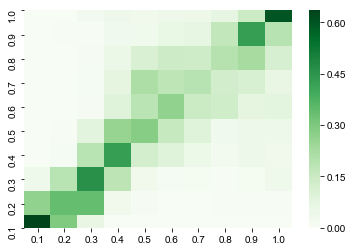

<Figure size 1800x1800 with 0 Axes>

In [7]:
# this makes a confusion matrix (heat map of percentage classified)

#this makes the confusion matrix into percentage of a true class, classified as each class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#output confusion matrix heatmap showing the percentage of each class prediction for a given true class, 
#over all true class observations 

x_axis_labels =  classes # labels for x-axis
y_axis_labels = np.flip(classes) # labels for y-axis
ax = sns.heatmap(np.flipud(cm_norm), cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

#here i used cm to create the heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(25, 25))
figure = ax.get_figure()

#save the figure
plt.savefig('Final_LDA_ALL_Bin.tif', bbox_inches="tight", dpi=600)

In [8]:
#set number of unique classes
num_classes=len(np.unique(y))

#set num of folds
folds=1000

#this keeps track of how many times each class was in a test set throughout the k-fold crossvalidation
fold_count = np.zeros(num_classes)
#this gets sets an array with all the indices corresponding to the unique classes
#we'll refer to this below
idx = np.array(list(range(num_classes)))

#initialize performance metric arrays to hold the 
#respective values for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)
accuracy_scores = np.zeros(num_classes)

for i in range(folds):
    #define the data split for training and testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
    
    #standardize the both the training and test data using the training standard scalar
    sc = StandardScaler()
    #get standardizing factor of the training data variables, and then standardize
    X_train = sc.fit_transform(X_train)
    #apply same transformation to the test data
    X_test = sc.transform(X_test)

    # set and initialize the LDA model
    lda  = LinearDiscriminantAnalysis(n_components=4)
    #fit the model on the training data for these k-1 folds
    lda_fit = lda.fit(X_train, y_train)
    #make predictions on the test fold
    y_pred=lda.predict(X_test)
    
    #find precision, recall, and f1 score
    P=precision_recall_fscore_support(y_test,y_pred, labels = classes)
    
    #if any of the performance metrics are nan, set to zero 
    P[0][np.isnan(P[0])] = 0.0
    P[1][np.isnan(P[1])] = 0.0
    P[2][np.isnan(P[2])] = 0.0
    
    #sum the performane metrics so after crossvalidation we can get an average performance value
    precision+=P[0]
    recall+=P[1]
    f1_score+=P[2]
    
    #get confusion matrix for the test predictions
    cm=confusion_matrix(y_test,y_pred, labels=classes)
    
    #convert to percentage classified 
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #here accuracy for each class is the percentage of a given class 
    #that were correctly identified, i.e. TP / P = TP / (TP+FN)
    acc=np.array(np.diag(cm_norm))
    acc[np.isnan(acc)]=0.0
    accuracy_scores += acc
    

    #find which classes are not in the test set
    #in these cases the precision_recall_fscore_support function 
    #simply sets the performance metrics to zero
    missing_classes = set(y) - set(y_test)
    
    #find the indices corresponding to the missing classes
    missing_idx = np.where(np.isin(classes,list(missing_classes)))
    
    #get non_missing indices 
    update_idx = np.delete(idx, missing_idx)
    
    #update the fold count (add 1 each time) only for the classes that were actually
    #in the test set. 
    #e.g. if a class was not in the test set 3 of the 10 times we should not be dividing by k=10 
    #when averaging the performance metrics, but rather divide by 7.  
    fold_count[update_idx] += 1.0
    
#now average the scores for the 10 folds
precision /= fold_count
recall /= fold_count
f1_score /= fold_count
accuracy_scores /= fold_count

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

In [14]:
#define performance table with precsision, recall, and f1
performance_tbl = pd.DataFrame({'Class': classes, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_scores, 'F1': f1_score} )

#save this as an excel for later use:
performance_tbl.to_csv('All_Bin_LDA.csv')
performance_tbl

,Class,Precision,Recall,Accuracy,F1
0,0.1,0.662918,0.659508,0.659508,0.660123
1,0.2,0.418712,0.366433,0.366433,0.389661
2,0.3,0.407097,0.444204,0.444204,0.423793
3,0.4,0.345855,0.400328,0.400328,0.369952
4,0.5,0.269659,0.302937,0.302937,0.284119
5,0.6,0.262235,0.255368,0.255368,0.257479
6,0.7,0.289899,0.221711,0.221711,0.249997
7,0.8,0.275480,0.229911,0.229911,0.249507
8,0.9,0.345084,0.385142,0.385142,0.363002
9,1.0,0.526113,0.558240,0.558240,0.540594


The End!